# Lat-lon map plots of E3SM fields for model comparisons

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import xarray as xr
import xarray.ufuncs as xu   # for applying element-wise square root and square functions to dataset
import pandas as pd          # for working with date-time indexing
import cartopy.crs as ccrs   # map plots
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable  # to make reasonably-sized colorbars
import matplotlib.gridspec as gridspec
import glob

## Prepare the model output for evaluation

In [4]:
sim_dir = '/Users/jone003/tmp/ne30_comp/'

# store cases in a dictionary: key = shortname, value = E3SM Case name
cases = {'E3SM': 'ne30_ZM_intel_72L_nc48',
         'SP2-ECPP': 'ne30_SP2_ECPP_intel_72L_64x1_4km_nc144',
         'SP1-buggy': 'ne30_SP1_ntask5401_intel_72L_64x1_4km_nc144',
         'SP1-prescribed-aero': 'ne30_SP1_nochem_intel_72L_64x1_4km_nc144',
         'SP1-original': 'ne30_SP1_revert_intel_72L_64x1_4km_nc144'}

# Dictionary of monthly output xarray datasets:
monthly_output = {}
for case, prefix in cases.items():
    files_to_open = glob.glob(sim_dir + prefix + '.cam.h0.*')
    if files_to_open:
        monthly_output[case] = xr.open_mfdataset(sim_dir + prefix + '.cam.h0.*')
        
# Note to self: is this version more pythonic? Or more confusing? or both?
monthly_output = {case: xr.open_mfdataset(glob.glob(sim_dir + prefix + '.cam.h0.*')) for case, prefix in cases.items() 
                  if glob.glob(sim_dir + prefix + '.cam.h0.*')}

In [5]:
# Variables to plot, rescalings, etc. 
# monthly variables to plot:
monthly_2d_vars_to_plot = ('AEROD_v', 'CLDTOT', 'CLDLOW', 'CLDMED', 'CLDHGH', 
                           'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC',
                           'FSNS', 'FSNSC', 'FSNT', 'FSNTOA', 'FSNTOAC', 'FSUTOA',
                           'LHFLX', 'SHFLX', 'LWCF', 'SWCF', 'OMEGA500', 'PBLH',
                           'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'QFLX', 
                           'TAUX', 'TAUY', 'TGCLDCWP', 'TGCLDIWP', 'TGCLDLWP', 'TMQ', 
                           'TREFHT', 'TS', 'U10')
mm_per_day = 86400 * 1000
g_per_kg = 1000
rescalings = {'PRECC': mm_per_day, 'PRECL': mm_per_day, 'PRECSC': mm_per_day, 'PRECSL': mm_per_day}
plot_units = {'PRECC': 'mm/d', 'PRECL': 'mm/d', 'PRECSC': 'mm/d', 'PRECSL': 'mm/d',
              'AEROD_v': ' ', 'CLDTOT': ' ', 'CLDLOW': ' ', 'CLDMED': ' ', 'CLDHGH': ' '}

# All of the "SP" variables (taken from an example file)
monthly_sp_2d_vars_to_plot = tuple(name for name in monthly_output['SP1-prescribed-aero'] if 'SP' in name)

/Users/jone003/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.


## plotting and other helper functions

In [6]:
# Note! These calculations assume that there is no missing data. 
# This *should* be fine for model output, but ought to be more careful in the future.
def area_weighted_mean(da):
    """area-weighted mean of dataArray da"""
    weights = xu.cos(np.pi * da['lat'] / 180)
    return ((da.mean(dim='lon') * weights).sum() / weights.sum()).values.item()


def area_weighted_rmse(da):
    """area-weighted RMSE of anomaly da"""
    weights = xu.cos(np.pi * da['lat'] / 180)
    return (xu.sqrt(((da ** 2).mean(dim='lon') * weights).sum() / weights.sum())).values.item()

In [7]:
def toa_title(da, model_name, show_mean=True, show_rmse=False, units="", fmt='{:.2g}'):
    """Calculate mean and/or RMSE and return string to use as title in map plots
    
    inputs: 
        da - xarray dataarray with the data for spatial means (assumes lat/lon coordinates)
        model_name - model name to include in string
        show_mean - add global area-weighted mean to output string if true
        show_rmse - add global area-weighted rmse to output string if true
        units - optionally specify units
        fmt - optionally specify formatting string form mean and rmse
    output: string to use for title of form "(mean) (model_name) (rmse) (units)"
    """
    #units = "W $\mathrm{m}^{-2}$"
    if show_mean:
        mn = ("Mean: " + fmt).format(area_weighted_mean(da))
    else:
        mn = ""
    if show_rmse:
        rmse = ("RMSE: " + fmt).format(area_weighted_rmse(da))
    else:
        rmse = ""
    return "{:12} {} {:>12}  ".format(mn, model_name, rmse) + units

#### Map layout

In [8]:
# Create a feature for states
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

def map_layout(ax, extent=None):
    """Add cartopy map to axis ax.
    """
    ax.add_feature(cfeature.LAND, alpha=0.2)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    # ax.add_feature(cfeature.LAKES)
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.2)
    # ax.add_feature(cfeature.RIVERS)
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree()) # CONUS
    else:
        ax.set_global()

# Global plot of single variable from dataset

In [9]:
def plot_global(v, ds, time_slice=None, projection=ccrs.LambertCylindrical(), extent=None,
                   rescale=1, units="", name='SP2-ECPP', cmap=None, mask_threshold=None):
    """ 2D Map plot of time-mean of ds[v].
    
    Arguments:
        v - variable to plot
        ds - xarray dataset containing variable v
        time_slice - optionally specify slice for time-mean.
                     if None, do mean over all times.
        projection - cartopy projection to use for map
        extent - optionally specify region for plotting (if None, do global plot)
        rescale - factor to rescale output by, so plotted_v = v * rescale
        units - optional string to specify units on map titles
        name - name used in plot title
        cmap - optionally specify colormap
        mask_threshold - optionally mask out values below mask_threshold
    """
    if time_slice is None:
        da = ds[v].mean(dim='time') * rescale
    else:
        da = ds[v].sel(time=time_slice).mean(dim='time') * rescale
        
    # set title before masking because my global mean functions are dumb
    ax_title = toa_title(da, model_name=name, show_mean=True, show_rmse=False, units=units)
    if mask_threshold is not None:
        da.values[da.values < mask_threshold] = np.nan
    fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': projection})
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
    if cmap is None:
        da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_ax=cax,
                         robust=True)
    else:
        da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_ax=cax,
                         robust=True, cmap=cmap)        
    map_layout(ax, extent)
    ax.set_title(ax_title)

### Sample output

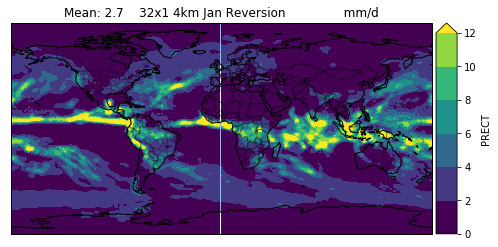

In [26]:
plot_global('PRECT', ds, time_slice=None, rescale=86400000, units='mm/d', name='32x1 4km Jan Reversion', projection=ccrs.PlateCarree())

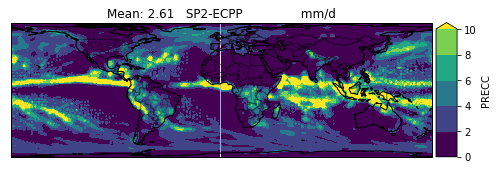

In [20]:
plot_global('PRECC', ds_aero, time_slice=None, rescale=(86400 * 1000), units='mm/d')

# Multi-model comparison plots

In [13]:
def multi_model_canvas(n, figsize=None):
    """subplot array (nrows, ncols) = (n, n+1) with last column scaled 5% for colorbar
    
    Helper function called by multi_model_global_plot.
    """
    if figsize is None:
        figsize = (8*n, 3*n)
    width_ratios = [1] * n + [0.05]
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(n, n + 1, width_ratios=width_ratios)
    return fig, gs


def multi_model_global_plot(v, ds_dict, names, time_slice=None, isel_times=None,
                            projection=ccrs.LambertCylindrical(), extent=None, 
                            rescale=1, units="", cmap_div=plt.cm.RdBu_r, fmt='{:.3g}',
                            vmin=None, vmax=None):
    """Plot time-mean of variable v (and anomalies) on global map for datasets in ds_dict
    
    Each column corresponds to a model run. The top row plots the time-mean of the data.
    The second row shows the anomaly of "v" relative to the data in the first column,
    the 3rd row shows the anomaly of "v" relative to the data in the second column, 
    and so on. Colorbars at the end of each row are common for the row.
    
    Inputs:
        v - variable to plot
        ds_dict - dictionary with (key, val) = (model_name, dataset)
        names - list containing the names of models to show on plot
                (expected to be keys of ds_dict)
        time_slice - optionally specify slice for time-mean.
                     if None, do mean over all times.
        isel_times - optionally specify indices for time-mean
                     only valid if time_slice is None
        projection - cartopy projection to use for map
        extent - optionally specify region for plotting (if None, do global plot)
        rescale - factor to rescale output by, so plotted_v = v * rescale
        units - optional string to specify units on map titles
        cmap_div - optionally specify colormap for the "delta" plots
        fmt - formatting string passed to toa_title
        vmin, vmax - optionally specify range for colorbar
        
    Notes:
      - names is emptied while this function is called
      - I need to find a better way to set mins and maxes of the colorbars, but I want 
        to make sure that the colorbar matches the colormaps for each subplot. I should
        see if this approach here is really necessary.
    """
    
    fig, gs = multi_model_canvas(len(names))
    
    # prep data_array
    dat = {key: ds_dict[key][v] * rescale for key in names if key in ds_dict}
    
    # try to get units if none are supplied
    if not units:
        for key in dat:
            try:
                units = ds_dict[key][v].attrs['units']
            except:
                pass
    
    # subset in time and average
    for key, val in dat.items():
        if time_slice is None:
            if isel_times is not None:
                dat[key] = val.isel(time=isel_times).mean(dim="time")
            else:
                dat[key] = val.mean(dim="time")
        else:
            dat[key] = val.sel(time=time_slice).mean(dim="time")
            
    # top row: just plot the data
    if vmin is None:
        vmin = np.min([np.nanmin(v.values) for v in dat.values()])
    if vmax is None:
        vmax = np.max([np.nanmax(v.values) for v in dat.values()])
    
    cbax = fig.add_subplot(gs[0, -1])
    for col, model in enumerate(names):
        ax = fig.add_subplot(gs[0, col], projection=projection)
        if model in dat:
            dat[model].plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                                     cbar_ax=cbax, vmin=vmin, vmax=vmax)
            map_layout(ax, extent)
            ax.set_title(toa_title(dat[model], model_name=model, show_mean=True, show_rmse=False, units=units, fmt=fmt))
    
    # for remaining rows, plot differences:
    # note to self: someday find a better way to do this
    row = 0
    key = names.pop(0) # pop first element -- this will be the new "obs"
    while names:
        row = row + 1
        d0 = dat.pop(key)

        # update data with difference from d0
        dat.update((k, val - d0) for k, val in dat.items())
        vmin = np.min([np.nanmin(v.values) for v in dat.values()])
        vmax = np.max([np.nanmax(v.values) for v in dat.values()])
        
        vmax = np.max([abs(vmin), abs(vmax)])
        vmin = -vmax
        cbax = fig.add_subplot(gs[row, -1])
        
        for col, model in enumerate(names):
            ax = fig.add_subplot(gs[row, row + col], projection=projection)
            if model in dat:
                dat[model].plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                                         cbar_ax=cbax, vmin=vmin, vmax=vmax, cmap=cmap_div, robust=True)
                map_layout(ax, extent)
                ax_name = ' - '.join([model, key])
                ax.set_title(toa_title(dat[model], model_name=ax_name, show_mean=True, show_rmse=True, units=units, fmt=fmt))
        key = names.pop(0)

### Sample output

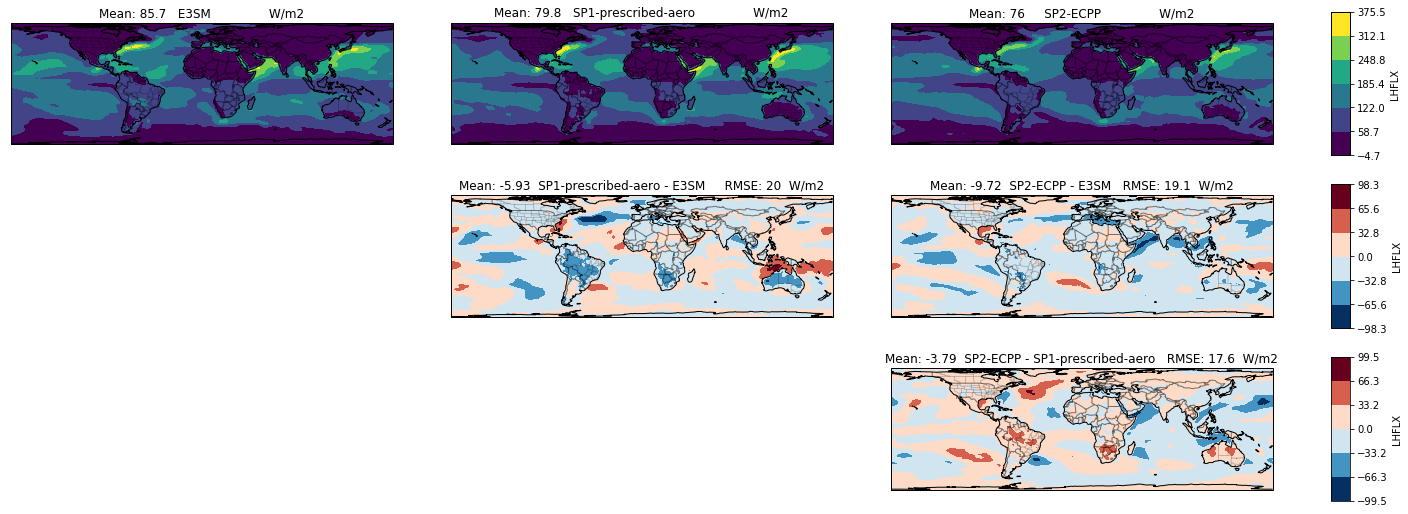

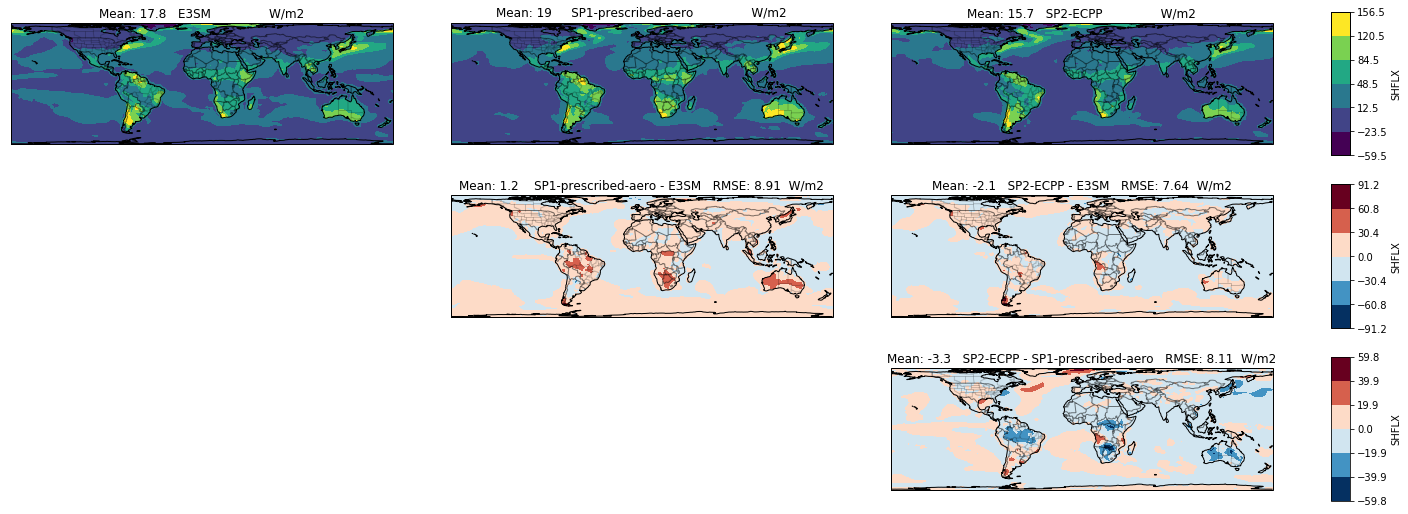

In [14]:
multi_model_global_plot('LHFLX', monthly_output, ['E3SM', 'SP1-prescribed-aero', 'SP2-ECPP'])
multi_model_global_plot('SHFLX', monthly_output, ['E3SM', 'SP1-prescribed-aero', 'SP2-ECPP'])

/Users/jone003/anaconda/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


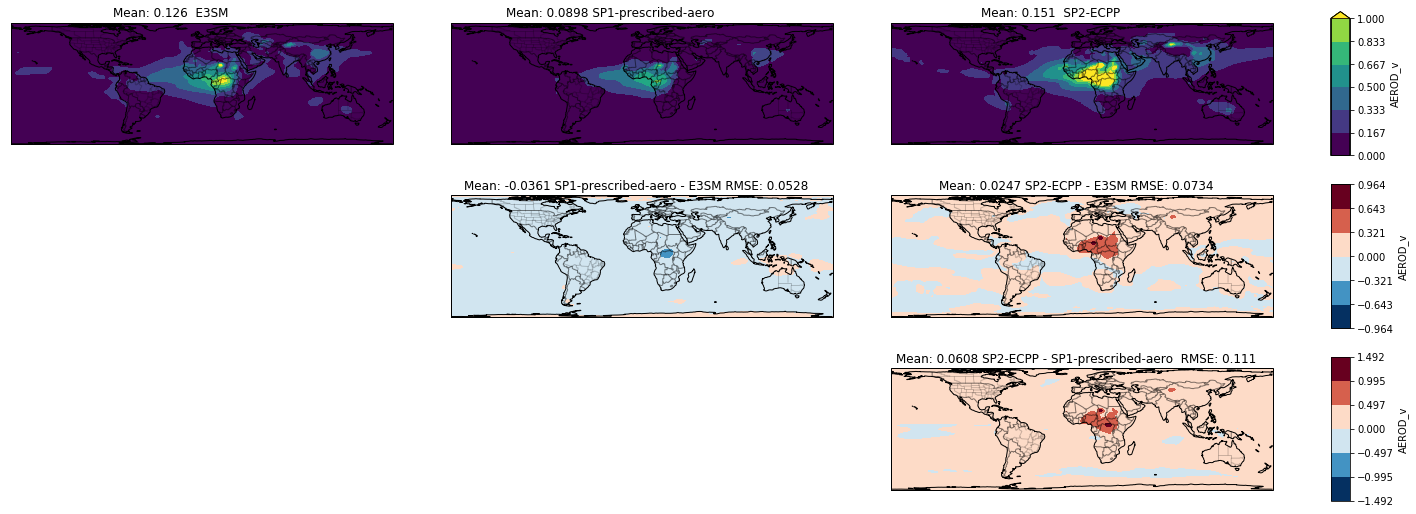

In [106]:
multi_model_global_plot('AEROD_v', monthly_output, ['E3SM', 'SP1-prescribed-aero', 'SP2-ECPP'], vmin=0, vmax=1, units=' ')

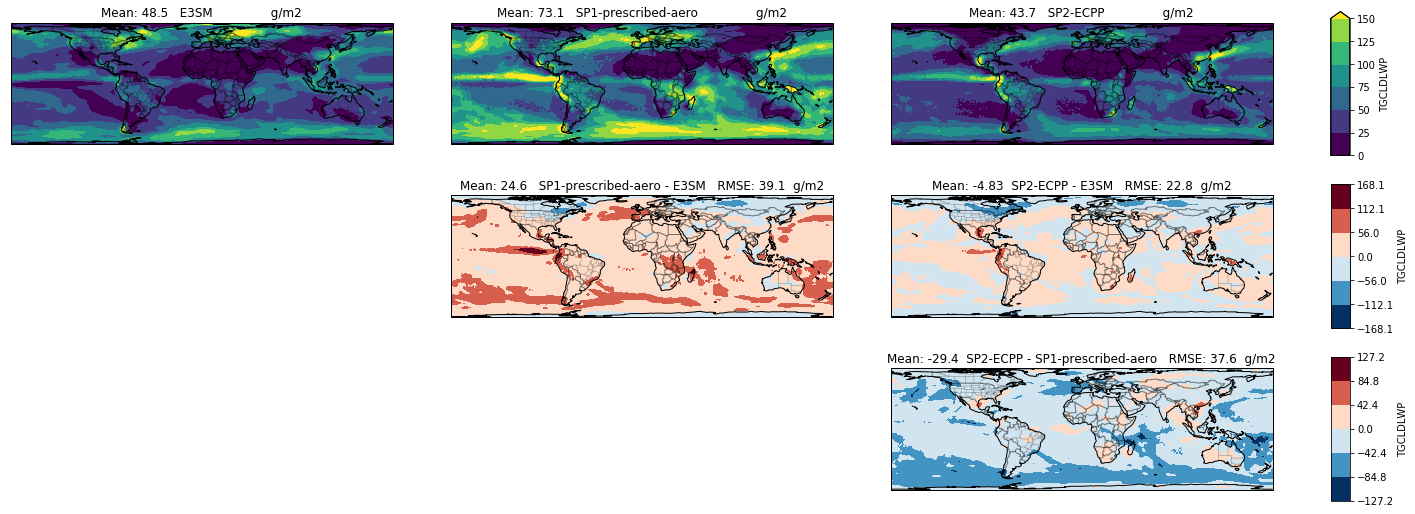

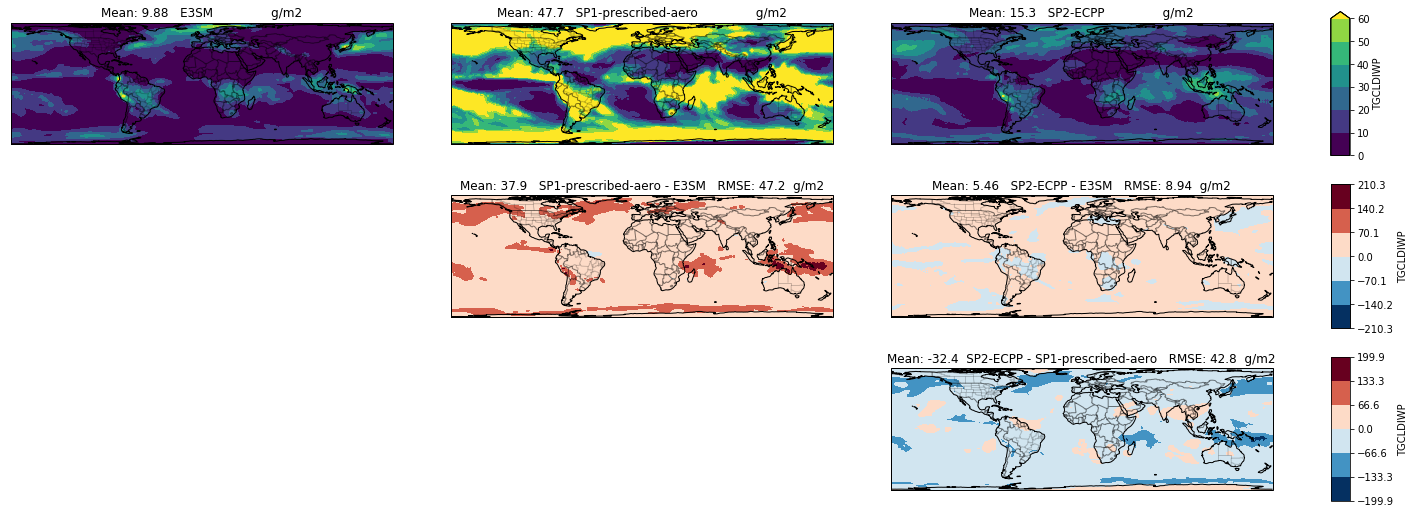

In [111]:
gm2 = "g $\mathrm{m}^{-2}$"
multi_model_global_plot('TGCLDLWP', monthly_output, ['E3SM', 'SP1-prescribed-aero', 'SP2-ECPP'], vmin=0, vmax=150, units=gm2, rescale=1e3)
multi_model_global_plot('TGCLDIWP', monthly_output, ['E3SM', 'SP1-prescribed-aero', 'SP2-ECPP'], vmin=0, vmax=60, units=gm2, rescale=1e3)

In [ ]:
# example loop (output suppressed)
for v in monthly_2d_vars_to_plot:
    print(v)
    rescale = rescalings[v] if v in rescalings else 1
    units = plot_units[v] if v in plot_units else ''
    multi_model_global_plot(v, monthly_output, ['E3SM', 'SP1-prescribed-aero', 'SP2-ECPP'],
                            rescale=rescale, units=units)

# E3SM Unstructured grid plot
Thanks to Ben Hillman for the tutorial on this. This should be turned into a plotting function at some point

In [15]:
# prepare data
dsu = xr.open_dataset('/Users/jone003/tmp/ne30_comp/ne30_SP1_jan19_intel_72L_32x1_4km_nc96.cam.h2.1999-12-01-00000.nc')
prect = dsu['PRECT'].mean(dim='time') * 86400 * 1000
lat = dsu.lat.values
lon = dsu.lon.values
lon[lon > 180] = lon[lon > 180] - 360  # convert to -180, 180

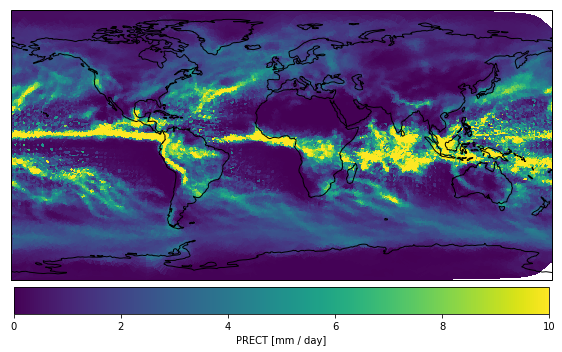

In [16]:
# prepare canvas and plot
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
p = ax.tripcolor(lon, lat, prect, transform=ccrs.PlateCarree(), vmin=0, vmax=10)
cb = plt.colorbar(p, orientation='horizontal', shrink=0.8, pad=0.02,
                  label='PRECT [mm / day]')